In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
#from jupyterthemes import jtplot
#jtplot.style(theme='solarizedd', context='notebook',
#             ticks=True, grid=False)

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:2'

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


### Create signal

In [2]:
FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

log_z = np.log(states[:,2])

MU_Z = np.mean(log_z)
signal = log_z-MU_Z

M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(states[:TRAINLENGTH+TEST,2]) - \
         np.min(states[:TRAINLENGTH+TEST,2])
STD = np.std(states[:TRAINLENGTH+TEST,2])

BINS = 50

print(f'Signal length M={M}')
print(f'Normalizing value max-min id {MINMAX:.3f}')
print(f'Normalizing value max-min id {STD:.3f}')

Signal length M=15000
Normalizing value max-min id 46.872
Normalizing value max-min id 8.567


### Helper functions and plotting parameters

In [3]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)

fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

### Load and save dicts

In [4]:
#with open('Dicts0/diagZ.json', 'w') as fp:
#    json.dump(dict_diag, fp, cls=NumpyArrayEncoder)
#with open('Dicts0/modelsZ.json', 'w') as fp:
#    json.dump(dict_models, fp, cls=NumpyArrayEncoder)

fpath = 'Dicts0/diagZ.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts0/modelsZ.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

### Plot models counts

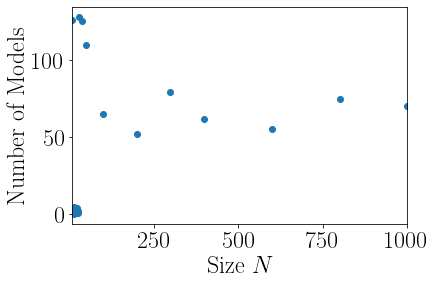

In [5]:
size = [1000,800,600,400,300,200,100,50,40,30,28,26,24,22,20,18,16,14,12,10]

mean_errors = []
num_models = []

for i in size:
    try:
        err = np.max(dict_diag[str(i)]['meanError'])
    except:
        err = 0
    if(np.isnan(err)):
        err=0
    mean_errors.append(err)
    
    try:
        num = dict_diag[str(i)]['numModels']
    except:
        num = 0
    if(np.isnan(err)):
        num = 0
    num_models.append(num)
#np.save('num_modelsZ',num_models)

plt.scatter(size[::-1],num_models[::-1])
plt.xlabel('Size $N$')
plt.ylabel('Number of Models')
plt.show()

In [ ]:
#np.save('mean_errorLz_2',mean_errors)

In [10]:
np.min(signal)

-3.1254466245794017

Skipped 17


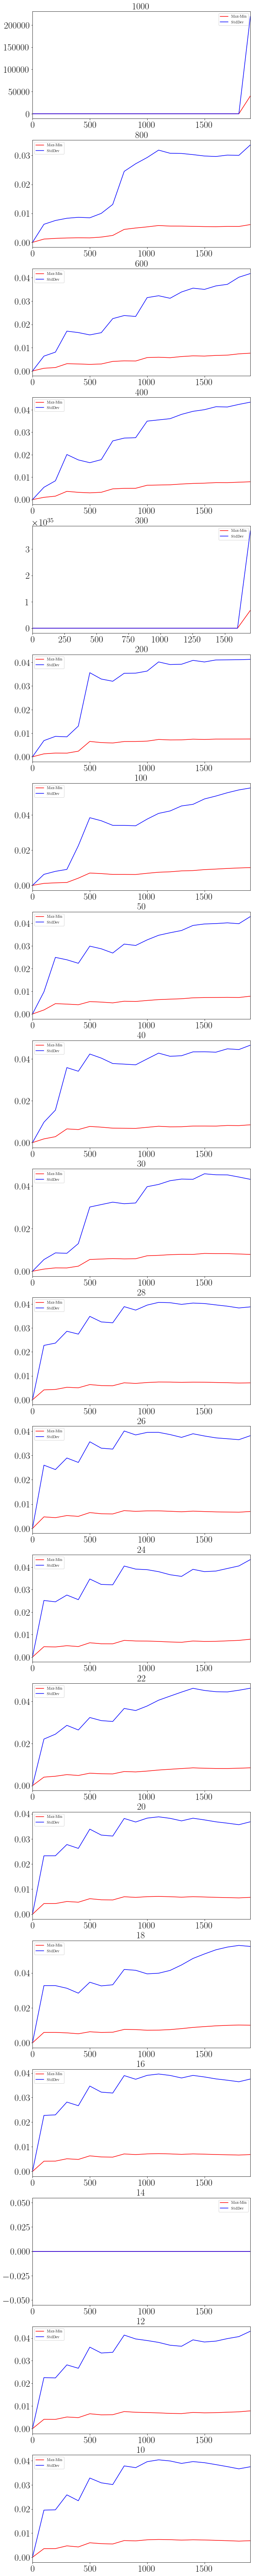

In [18]:
import pdb
def debug():
    #pdb.set_trace()
    Nplots= len(size)
    #axs[0].set_title('Signal $Lx$ predictions $t=0,\dots,T^{\rm test}-1$')
    segment_errMM = np.zeros((Nplots,20)) 
    segment_errSTD = np.zeros((Nplots,20))
    seglengths = np.zeros((1,20))
    for n in range(Nplots):
        try:
            preds = np.squeeze(np.array(dict_models[str(size[n])]['Preds']))
        except:
            print(f'Skipped {n}')
            continue
        for i in range(1,20):
            sigchk = signal[TRAINLENGTH:TRAINLENGTH+i*100]
            predschk = preds[TRAINLENGTH:TRAINLENGTH+i*100]
            predschk = np.nan_to_num(predschk, nan=5)
            errMM = rca.NRMSE(sigchk,
                              predschk,
                              MINMAX)
            errSTD = rca.NRMSE(sigchk,
                               predschk,
                               STD)
            segment_errMM[n,i] = errMM
            segment_errSTD[n,i] = errSTD
            seglengths[0,i] = i*100

    fig, axs = plt.subplots(Nplots, figsize=(10,6*Nplots)) 
    for n in range(Nplots):
        axs[n].set_title(f'{size[n]}')
        axs[n].plot(seglengths[0,:], segment_errMM[n,:],
                 color='r', label=f'Max-Min')
        axs[n].plot(seglengths[0,:], segment_errSTD[n,:],
                 color='b', label=f'StdDev')
        axs[n].legend()
    plt.show()
    
debug()

In [ ]:
MM = np.max(signal[:TRAINLENGTH + TEST])-np.min(signal[:TRAINLENGTH + TEST])
MM

Nplots= len(size)
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
axs[0].set_title('Signal $Lz$ predictions $t=0,\dots,T^{\rm test}-1$')
for n in range(Nplots):
    if(dict_diag[str(size[n])]['numModels']==0):
        continue
    axs[n].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST], color='k', label='target')
    preds = np.array(dict_models[str(size[n])]['Preds'])
    error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              MM)
    kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                                preds[TRAINLENGTH:TRAINLENGTH + TEST],
                                 np.min(signal[:TRAINLENGTH+TEST]),
                                 np.max(signal[:TRAINLENGTH+TEST]),
                                 bins=50)
    ekl = error_testset*kl
    print(f'N={size[n]}   Error = {np.round(error_testset,2)} KL-div = {np.round(kl,2)} ekl = {ekl:.3f}')
    axs[n].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST],
             color='b', label=f'preds{size[n]}')
    axs[n].legend()
plt.show()

### Calculate Rank Method-1 for all sizes

In [ ]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)
all_ranks = []
measured = []
K = 1
L = 1
tols = [1/10**x for x in range(0,20)]
plt.figure()
for i in range(Nplots):
    n = size[i]
    print(n)
    if(dict_diag[str(n)]['numModels']==0):
        all_ranks.append(0)
        measured.append(n)
        continue
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    sr = p[1]
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    grads = np.gradient(rkc)
    v = np.argmax(grads)
    #print(grads)
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50, color='k')
    ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Targeted reduced rank for N={n} is {ave_rank}\nValue v= {v} Tolerance {tols[v]} Rho A {rhoA.round(2)}')
    print(f'Alpha {np.round(a,2)} --- Rho {np.round(sr,2)}\n')
    all_ranks.append(ave_rank)
    measured.append(n)
plt.title('Rank vs Tolerance for various size $N$')
plt.xlabel('Tolerance $\epsilon > 10^{-x}$')
plt.ylabel('$\mathrm{rank(C_{N};\epsilon)}$')
plt.ylim(0,50)
plt.show()

In [ ]:
#np.save('ranksZ_2',all_ranks)

### Log-Log plot of rank vs sizes

In [ ]:
plt.loglog(size[::-1],all_ranks[::-1], label='indicated')
plt.loglog(size[::-1],size[::-1], label='N')
plt.xlabel('Size $N$')
plt.ylabel('$\mathrm{rank}(C_N)$')
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()

### Get time-step of divergence 

In [ ]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))
FREE =1000
T = M + FREE
Nsizes = len(size)
correlations = np.zeros((Nsizes,T))
thresholds = np.zeros(Nsizes)
threshold_location = np.zeros(Nsizes, dtype=int)
for i in range(Nsizes):
    if(dict_diag[str(size[i])]['numModels']==0):
        continue
    k = size[i]
    corr_length = T-k # calculate for j= 0,..., M-k
    pred = np.array(dict_models[str(k)]['Preds']) # Get size N predictions
    
    for j in range(corr_length):
        tar = signal[j:j+k].reshape((k,1))
        prd = pred[j:j+k].reshape((k,1))
        correlations[i,j] = Rxy(tar,prd)

    minVal = correlations[i,TRAINLENGTH-1000:TRAINLENGTH].min()
    thresholds[i] = minVal*.95
    threshold_location[i] = np.where(correlations[i,TRAINLENGTH:]<thresholds[i])[0][0]
    print(f'k-size={k} Trainingset min={minVal.round(3)}  threshold={thresholds[i]:.3f}',
          f' Location={threshold_location[i]}')


### Plot divergence

In [ ]:
LEAD = 100
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
for n in range(Nsizes):
    if(dict_diag[str(size[n])]['numModels']==0):
        continue
    pred = dict_models[str(size[n])]['Preds']
    axs[n].plot(signal[TRAINLENGTH-LEAD:TRAINLENGTH+TEST], color='k', label='target')
    axs[n].plot(pred[TRAINLENGTH-LEAD:TRAINLENGTH+TEST],color='b', label='pred')
    axs[n].plot(correlations[n,TRAINLENGTH-LEAD:TRAINLENGTH+TEST], color='r', label=f'k={size[n]}')
    axs[n].axvline(LEAD+threshold_location[n],color='r', linestyle='dashed', label=f't={threshold_location[n]}')
    axs[n].axvline(LEAD,color='k')
    axs[n].axhline(thresholds[n],color='r', linestyle='dashed')
    axs[n].set_ylabel('$\mathbf{R}_{xy}[k]\enspace ,\enspace Lz$')
    axs[n].set_xlabel('Time-steps $t$')
    axs[n].legend(fontsize=24,loc='lower right')
axs[0].set_title('Correlation (solid red) at $t$-step (dashed red), $\mathbf{R}_{xy}[k]<\mathrm{threshold}$ (dotted red) ')
plt.show()

### Chaos journal plot

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.gridspec as gridspec
def rank_along_trajectory(wr, wi, a, g, forcing, n, k, tolerance):
    T = forcing.shape[0]
    ranks = np.zeros(T)
    radii = np.zeros(T)
    def Func(x):
        return np.squeeze(-x.reshape(n,1) + (1-a)*x.reshape(n,1) +\
                          a*g*np.tanh(np.dot(wr,x.reshape(n,1)) +\
                         (np.dot(wi,ueq.reshape(k,1)).reshape(n,1))))
    for i in range(T):
        ueq = forcing[i]
        x0 = np.ones((n,1))*.5
        xeq = (fsolve(Func,x0)).reshape(n,1)
        A = rca.leaky_jacobian(xeq, ueq.reshape(k,1), a, g, wi, wr)
        radii[i] = np.max(np.abs(rca.eig_spectrum(A)))
        B = rca.partial_u(xeq, ueq.reshape(k,1), a, g, wi, wr)
        Cplus = rca.gpu_reachable_matrix(A, B)
        ranks[i] = rca.rank(Cplus, tolerance)
    return ranks, radii

N = 30
K = 1
v = 5
pred = np.array(dict_models[str(N)]['Preds'])
start, end= 13900,15000
p = dict_models[str(N)]['Params']
mat = np.array(dict_models[str(N)]['Wnet'])
Wr, Wi = rca.get_mats(None, K,N, matrix=mat)
sig_rks, radii = rank_along_trajectory( Wr, Wi, p[0], p[2],
                            signal[start:end], N, K, tols[v])
pred_rks,_ = rank_along_trajectory( Wr, Wi, p[0], p[2],
                            pred[start:end],N, K, tols[v])

gs = gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=(10,14))
ax1 = plt.subplot(gs[0])
fontsize = 28
unsignal = states[:,2]

preds = np.exp(np.array(dict_models['30']['Preds'])+MU_Z)
pred = np.array(dict_models['30']['Preds'])
data_dict = {'y': unsignal[-2000:],
             'yh': np.squeeze(preds[-2000:]),
            }

alpha = .5
bins = 50 #np.arange(0,48,48/75)#17
df = pd.DataFrame(data=data_dict)
sns.distplot(df['y'],
             label='$Lv^{(3)}$',
             bins=bins,
             color='k',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=.5),
             ax=ax1)
sns.distplot(df['yh'],
             label='$\widehat{\mathbf{y}},\enspace N=30$',
             bins=bins,
             color='b',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=.3),
             ax=ax1)
ax1.legend(handlelength=.5,loc='upper right', fontsize=fontsize-4)
ax1.set_ylabel(r'${P}(v^{(3)}_t)$', fontsize=fontsize,  color='black', weight='heavy', labelpad=10)
ax1.set_xlabel(r'Range of $v^{(3)}_t$', fontsize=fontsize,  color='black', weight='heavy')
ax1.text(-0.2, 1.,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')



start, end= 13900,14650
xax = [k for k in range(start,end)]
plt.rcParams['xtick.major.pad']='8'
gs1 = gs[1].subgridspec(2,1, hspace=.02)

ax2 = plt.subplot(gs1[0])

ax2.plot(xax,signal[start:end],'k', label=r'$Lv^{(3)}$', alpha= .8)
ax2.plot(xax,pred[start:end],'b-', label='$\widehat{y},\enspace N=30$', alpha = .8)

ax2.legend(loc='upper right',
           handlelength=.5,
           ncol=2,
           fontsize=24,
           borderpad=.2,
           borderaxespad=.2)

ax2.set_ylabel(r'$\log{v^{(3)}_t}-\mu_{\log{v^{(3)}}}$', fontsize=fontsize,  color='black', weight='heavy')
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.set_xticks([])
ax2.set_ylim(-1, 1.2)

ax3 = plt.subplot(gs1[1])
ax3.text(-0.2, 0,s='$(\mathbf{c})$', transform=ax2.transAxes, 
            size=30, weight='bold')

lowlim, uplim = 0,30
ax3.plot(xax,sig_rks[:750],
        color='k', lw=1, label='$Lv^{(3)}$', alpha=.8)
ax3.plot(xax,pred_rks[:750],
        color= 'b', ls='--', lw=1, label='$\widehat{\mathbf{y}},\enspace N=30$', alpha=.8)

ax3.set_ylim(12, 28)
ax3.set_ylabel('$\mathrm{rank}(\mathbf{\mathcal{C}}_{30};10^{-5})$', labelpad=22)
ax3.set_xlabel('Time-step $t$')
ax3.set_xticks([13900,14000,14500])
ax3.set_xticklabels([-100,0,500])

ax2.axvline(14000, c='k',ls='dashed' )
ax2.axvline(14308, c='r',ls='dashed' )

ax3.axvline(14000, c='k',ls='dashed' )
ax3.axvline(14308, c='r',ls='dashed' )
ax1.grid()
ax2.grid()
ax3.grid()
plt.tight_layout()
plt.show()
#fig.savefig("../PlotNBs/NBoutputs/Lz_lines_combined.pdf", format='pdf', bbox_inches='tight', pad_inches=.01)